## ICONMAP project miRNA data analysis

Reference:

D. Farrell, R. G. Shaughnessy, L. Britton, D. E. MacHugh, B. Markey, and S. V. Gordon, “The Identification of Circulating MiRNA in Bovine Serum and Their Potential as Novel Biomarkers of Early Mycobacterium avium subsp paratuberculosis Infection,” PLoS One, vol. 10, no. 7, p. e0134310, 2015.


In [4]:
import glob,os
import pandas as pd
import numpy as np
import mirnaseq.mirdeep2 as mdp
import mirnaseq.srnabench as srb
from mirnaseq import base, analysis, ensembl
pd.set_option('display.width', 130)
%matplotlib inline
import pylab as plt
base.seabornsetup()
plt.rcParams['savefig.dpi']=300
plt.rcParams['font.size']=16

In [2]:
reload(analysis)
reload(mdp)
path='/opt/mirnaseq/data/iconmap/'
os.chdir(path)
#mirdeep
path1 = 'analysis/iconmap_results_mirdeep'
ic = mdp.getResults(path1)
ic = mdp.filterExprResults(ic,meanreads=150,freq=0.8)
k = ic[ic.novel==False]
n = ic[ic.novel==True]
n=n[n['miRDeep2 score']>=4]
condmap1 = mdp.getLabelMap(path1,'samplelabels.csv')

#srnabench
path2 = 'analysis/iconmap_results_srnabench'
sk,sn,iso = srb.getResults(path2)
sk = srb.filterExprResults(sk,meanreads=150)
condmap2 = srb.getLabelMap(path2,'samplelabels.csv')


In [9]:
def DEbytime(df, condmap):
    status=['control','infected']
    res=[]
    for s in status:
        c = condmap[condmap.status==s]
        x = pd.Categorical(c['month'],categories=[0,6])
        c['factor'] = x.labels
        c['label'] = c.apply(lambda x: x.id+'_'+str(x.factor),1)
        c = c.sort('factor')    
        scols = c.id
        data = df[scols]    
        data.columns = c.label       
        data.to_csv('decounts.csv')
        de = base.runEdgeR('decounts.csv', 1.5)
        de['status']=s
        res.append(de)
        print de
    detime = pd.concat(res)    
    detime.to_csv('de_time.csv')
    return detime

In [4]:
#diff expr by time
df1 = pd.concat([k,n])
df1 = df1.set_index('#miRNA')
df2 = sk.set_index('name')
detime = DEbytime(df1, condmap1)


/usr/local/lib/python2.7/dist-packages/pandas-0.16.0-py2.7-linux-x86_64.egg/pandas/core/categorical.py:396: FutureWarning: 'labels' is deprecated. Use 'codes' instead
  warnings.warn("'labels' is deprecated. Use 'codes' instead", FutureWarning)
-c:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
-c:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 [1] "0" "0" "0" "0" "0" "0" "1" "1" "1" "1" "1" "1"

               name     logFC     logCPM    PValue       FDR   status
0       bta-miR-205  2.323181   8.635382  0.000002  0.000176  control
2    bta-miR-126-5p  1.706727   8.520117  0.000300  0.003967  control
3       bta-miR-143  1.702237  10.203733  0.000005  0.000184  control
4    bta-miR-27a-3p  1.633126  10.343266  0.000010  0.000287  control
5       bta-miR-92b  1.598428  10.845843  0.000074  0.001102  control
6       bta-miR-10b  1.570112  14.530603  0.000022  0.000429  control
114     bta-miR-127 -1.618129  11.239548  0.000027  0.000465  control
115     bta-miR-432 -1.916355   7.621927  0.000015  0.000351  control
116         9_25151 -1.966658  10.038651  0.000003  0.000176  control
117         13_4632 -2.044966   7.816529  0.004710  0.043461  control
118         4_20321 -2.347488   4.746192  0.000423  0.005028  control
 [1] "0" "0" "0" "0" "0" "0" "1" "1" "1" "1" "1" "1"

            name     logFC    logCPM        PValue  

In [5]:
def meltdata(df, labels):
    t=df.T
    t.index = cols    
    t = t.merge(labels,left_index=True,right_on='id')   
    tm = pd.melt(t,id_vars=list(labels.columns),
                 var_name='miRNA',value_name='read count')
    return tm

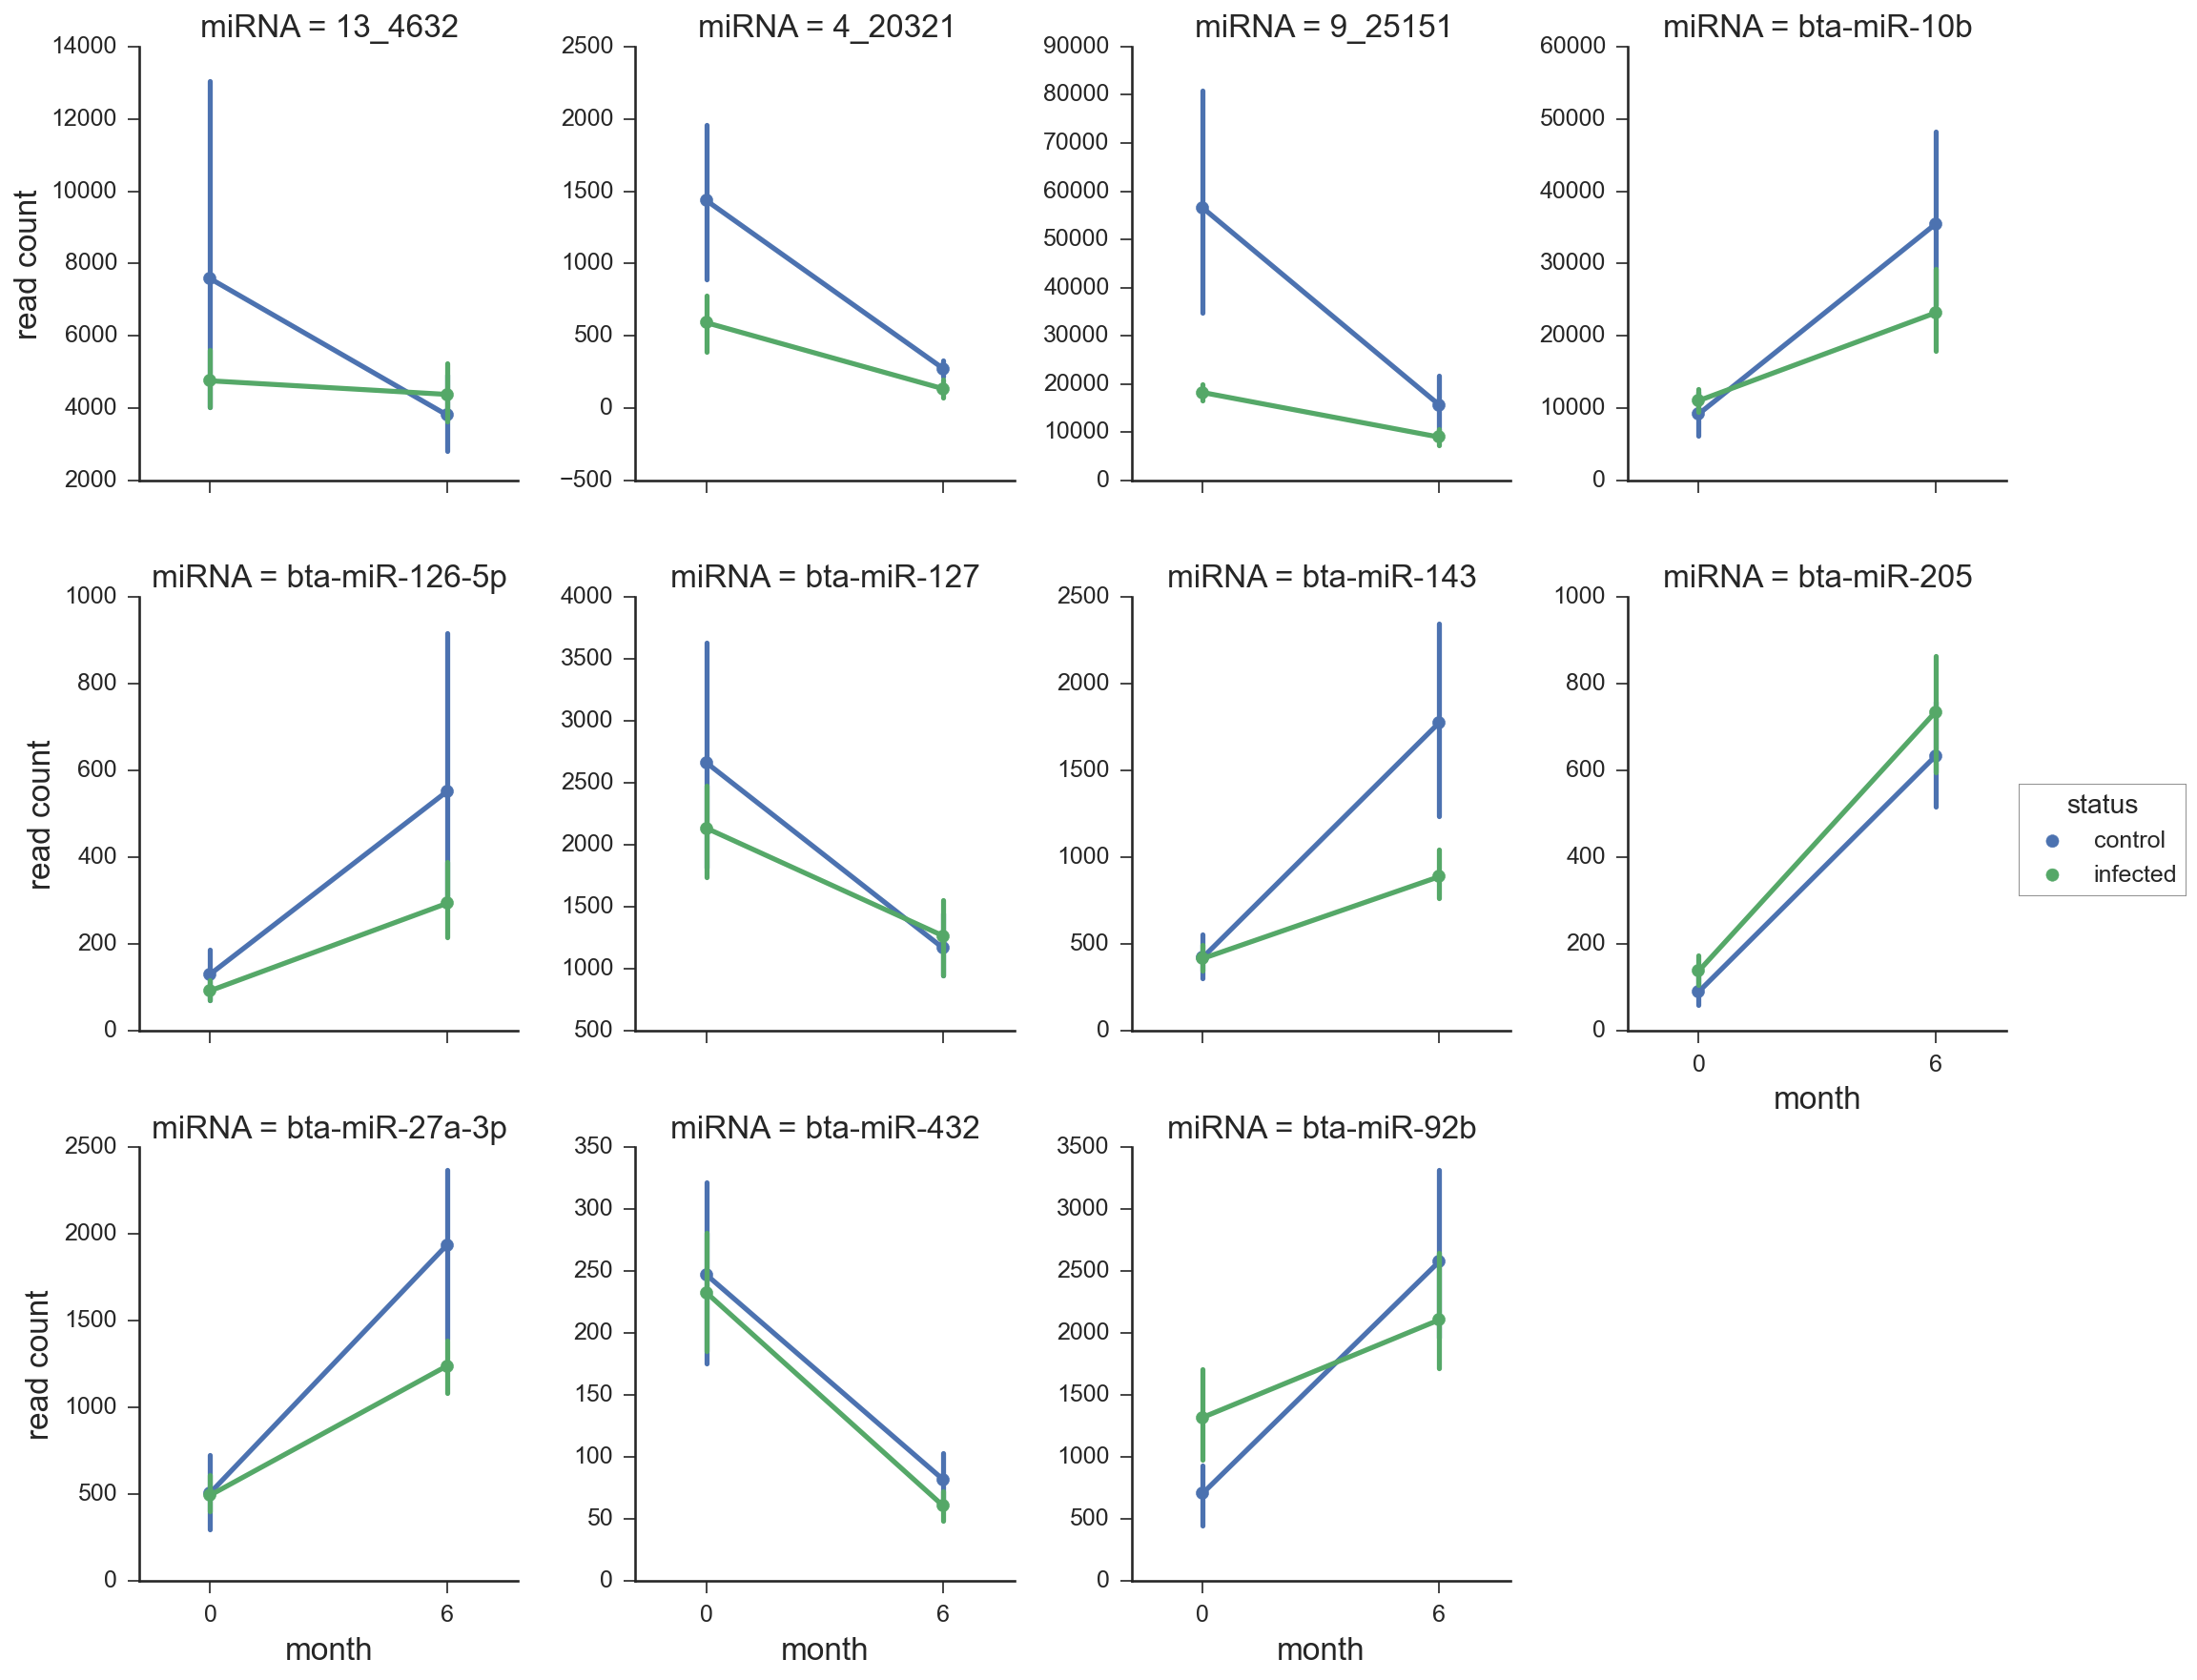

In [9]:
df = ic.set_index('#miRNA')
names = detime.name
#names=df.index[10:30]
cols,normcols = mdp.getColumnNames(df)
df = df.ix[names][normcols]

tm = meltdata(df,condmap1)

g = base.sns.factorplot('month','read count','status', tm, col='miRNA', kind="point",
                            col_wrap=4,size=4,aspect=0.9,legend_out=True,sharey=False)
plt.savefig('iconmap_DE_time.png')
#g = base.sns.factorplot('animal','read count', 'month',data=tm, col='miRNA', kind="bar",
#                         col_wrap=2,size=4,aspect=2,legend_out=True,sharey=False,palette='Set2')
#plt.savefig('iconmap_DE_time_animals.png')

In [39]:
def DEbystatus(df,condmap):
    #diff expr by infection
    status=['control','infected']
    months=[0,6]    
    res=[]
    for m in months:
        c = condmap[condmap.month==m]
        x = pd.Categorical(c['status'],categories=status)
        c['factor'] = x.labels
        c['label'] = c.apply(lambda x: x.id+'_'+str(x.factor),1)
        c = c.sort('factor')   
        scols = c.id   
        data = df[scols]    
        data.columns = c.label    
        data.to_csv('decounts.csv')
        de = base.runEdgeR('decounts.csv', 1.5)
        de['month']=m
        res.append(de)
        print de        
    deall = pd.concat(res) 
    return deall
        

In [ ]:
destatus = DEbystatus(df1, condmap1)

df = ic.set_index('#miRNA')
names = destatus.name
#names=df.index[10:30]
cols,normcols = mdp.getColumnNames(df)
df = df.ix[names][normcols]
tm = meltdata(df,condmap1)

g = base.sns.factorplot('month','read count','status', tm, col='miRNA', kind="box",
                            col_wrap=2,size=4,aspect=1,legend_out=True,sharey=False)
plt.savefig('iconmap_DE_status.png')
g = base.sns.factorplot('animal','read count','month', tm, col='miRNA', kind="bar",
                            col_wrap=2,size=3,aspect=2,legend_out=True,sharey=False)

In [10]:
#isomir diff expr
df3 = iso[(iso.mean_norm>50) & (iso.freq>0.9)]
df3['tag'] = df3.name+'_'+df3.variant+'_'+df3.index.astype(str) # +iso.read
df3 = df3.set_index('tag')
res = DEbytime(df3, condmap2)

 [1] "0" "0" "0" "0" "0" "0" "1" "1" "1" "1" "1" "1"

                           name     logFC     logCPM        PValue           FDR   status
0        bta-miR-205_lv3p_38283  2.583610   7.028488  2.111344e-10  4.338812e-08  control
1       bta-miR-205_exact_38284  2.435571   6.564262  2.559840e-05  4.102623e-04  control
2        bta-miR-205_lv3p_38279  2.281452   6.637006  6.139603e-08  4.587958e-06  control
3     bta-miR-27a-3p_lv3p_47828  2.243228   7.188335  2.058058e-08  2.679327e-06  control
4        bta-miR-27b_lv3p_47829  2.243225   7.188335  2.088398e-08  2.679327e-06  control
5     bta-miR-27a-3p_lv3p_47838  2.196640   7.927045  5.486711e-08  4.510753e-06  control
6      bta-miR-21-5p_lv3p_30254  2.167486   6.074332  1.173502e-07  6.890135e-06  control
7        bta-miR-10b_lv3p_28871  2.129061   8.733686  1.084041e-07  6.854474e-06  control
8       bta-miR-143_nta#T_42032  2.107948   8.182706  7.452607e-07  2.663497e-05  control
9        bta-miR-10b_lv3p_30855  2.105019   8.

-c:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
#res = res[res.logFC<2]
res = res.sort('logFC',ascending=False)
names=res.name[:30]
#names=df.index[10:30]
cols,normcols = srb.getColumnNames(df3)
df = df3.ix[names][normcols]
tm = meltdata(df,condmap2)
g = base.sns.factorplot('month','read count','status', tm, col='miRNA', kind="point",
                            col_wrap=4,size=3,aspect=1.5,legend_out=True,sharey=False)
g = base.sns.factorplot('animal','read count', 'month',data=tm, col='miRNA', kind="bar",
                         col_wrap=3,size=3,aspect=3,legend_out=True,sharey=False,palette='Set2')

# #compare methods reload(analysis) analysis.compareMethods('analysis/iconmap_results_mirdeep',                         'analysis/iconmap_results_srnabench')

In [ ]:
#isomir diversity comparisons
reload(srb)
#cols,normcols = srb.getColumnNames(iso)
#normcols.append('name')
df = iso.set_index('name')
#x=srb.getTopIsomirs(iso)

status=['control','infected']
month = [0,6]
for s in status:
    for m in month:        
        c = condmap2[(condmap2.month==m) & (condmap2.status==s)]
        scols = c.id#+'_norm'          
        data = df[scols].reset_index()
        #data = data[data.mean(1)>50]
        print data[:10]
        
        print s,m,len(data)
        x=srb.getTopIsomirs(data)
        print x[:2]
        

            #miRNA  total1  total2
38  bta-miR-99a-5p   19041   24132
42     bta-miR-99b   15819   24821
71     bta-miR-101    4240    9760


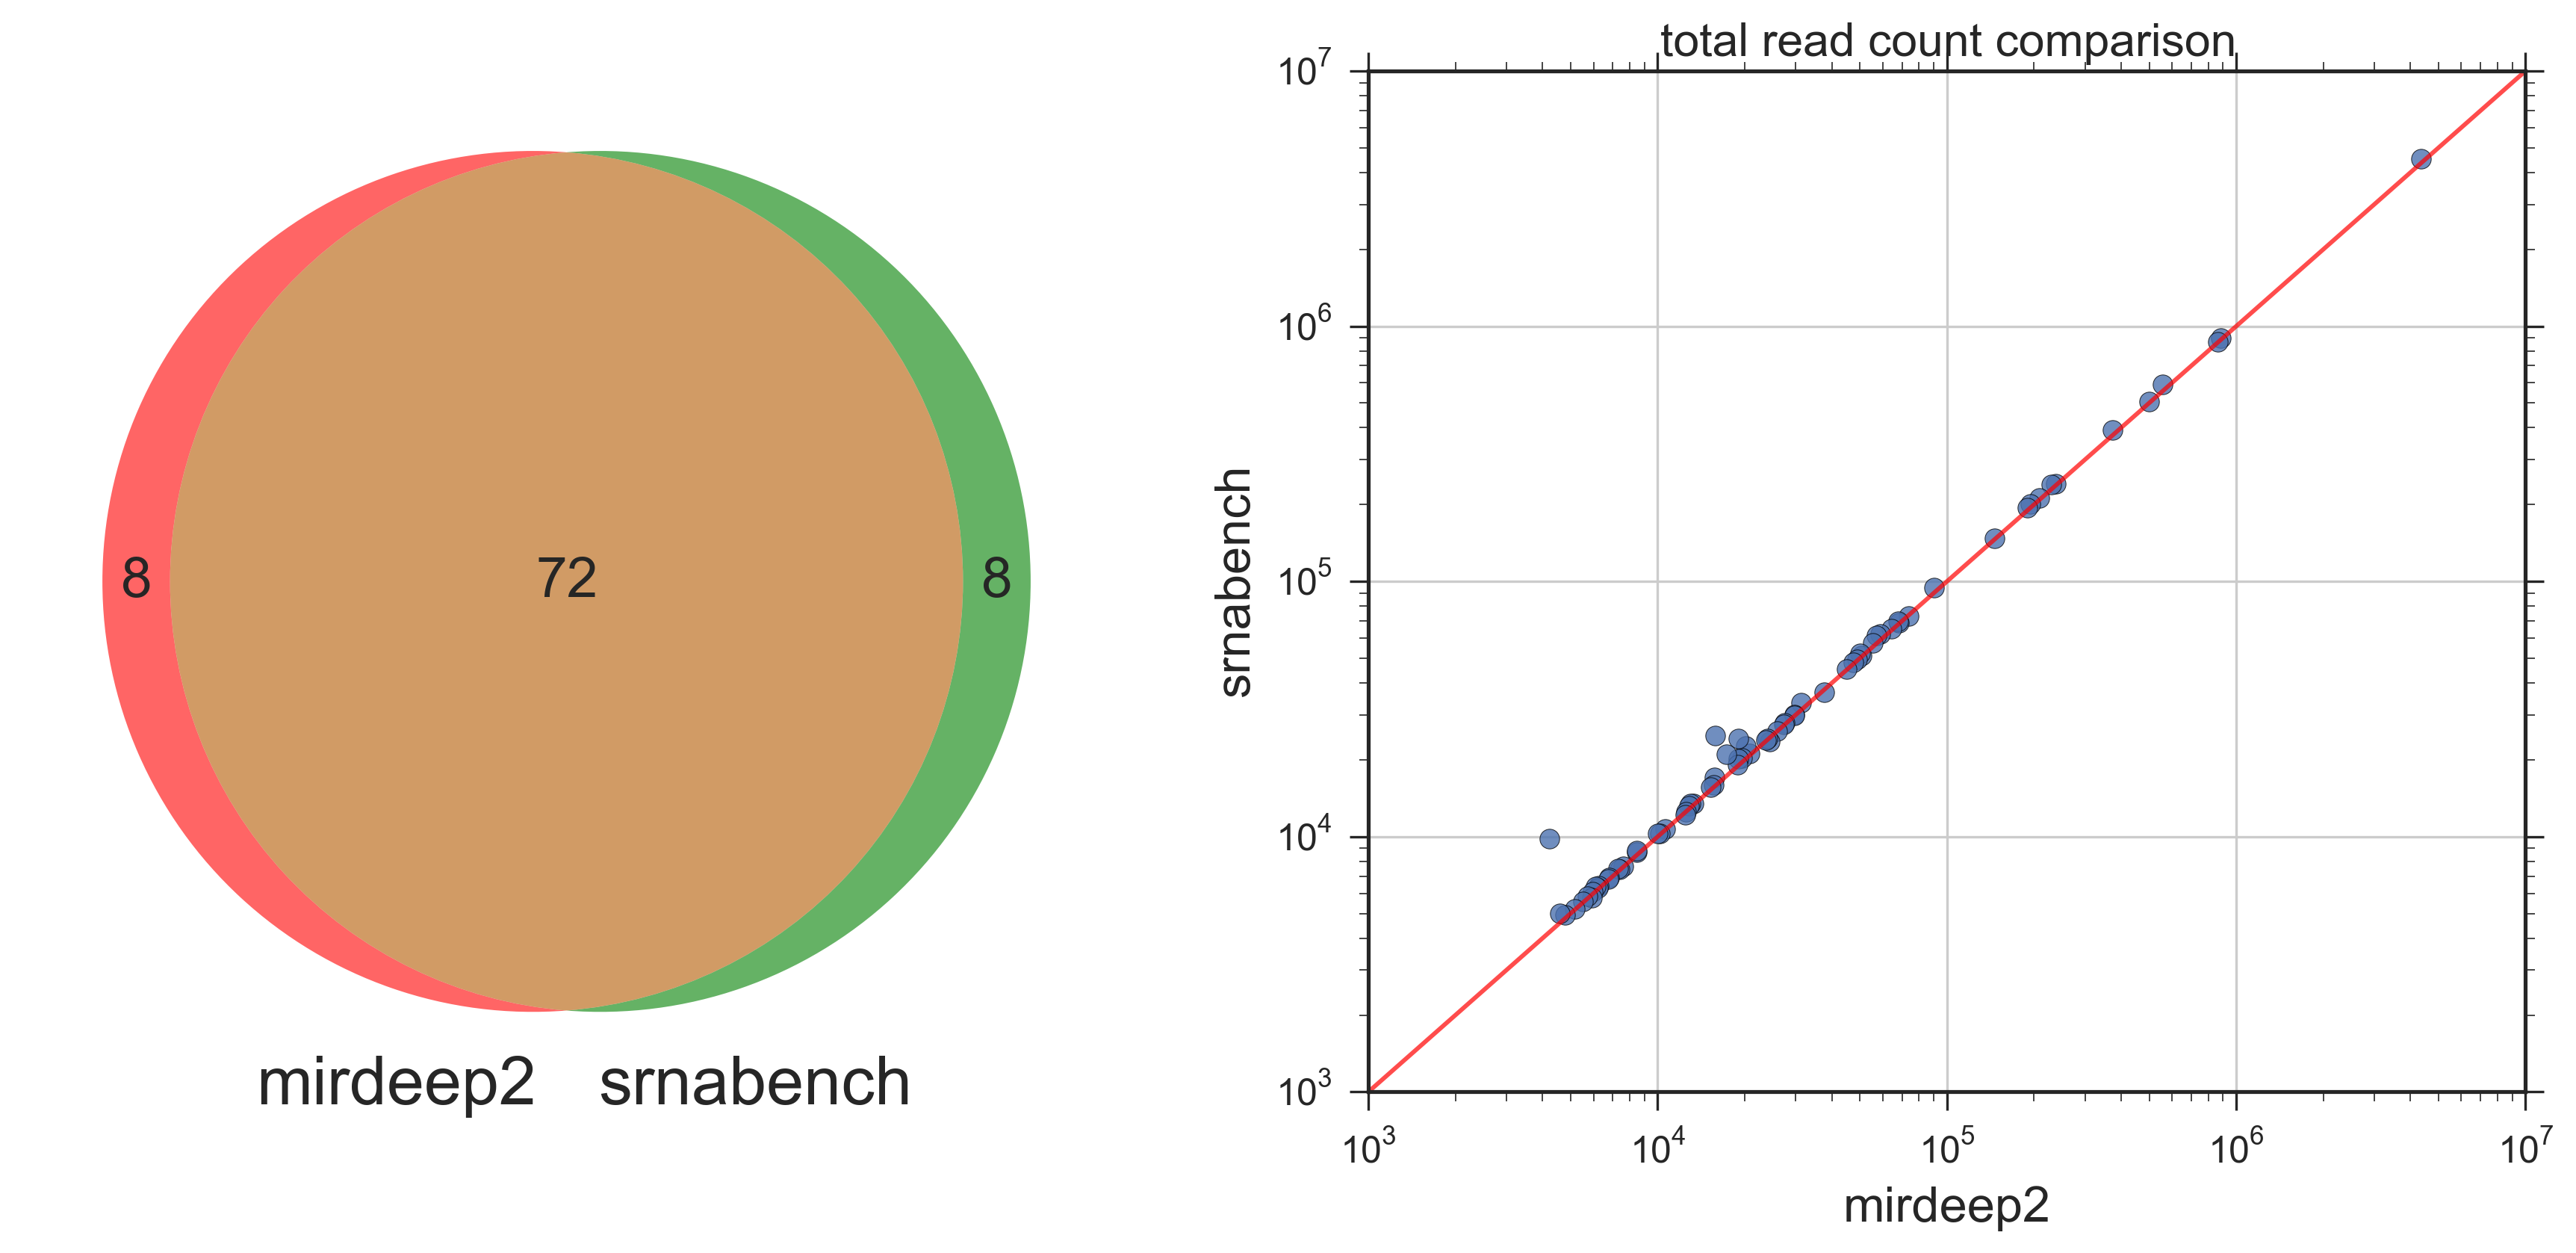

In [7]:
#compare methods reload(analysis) 
plt.rcParams['font.size']=18
analysis.compareMethods('analysis/iconmap_results_mirdeep', 
                        'analysis/iconmap_results_srnabench')

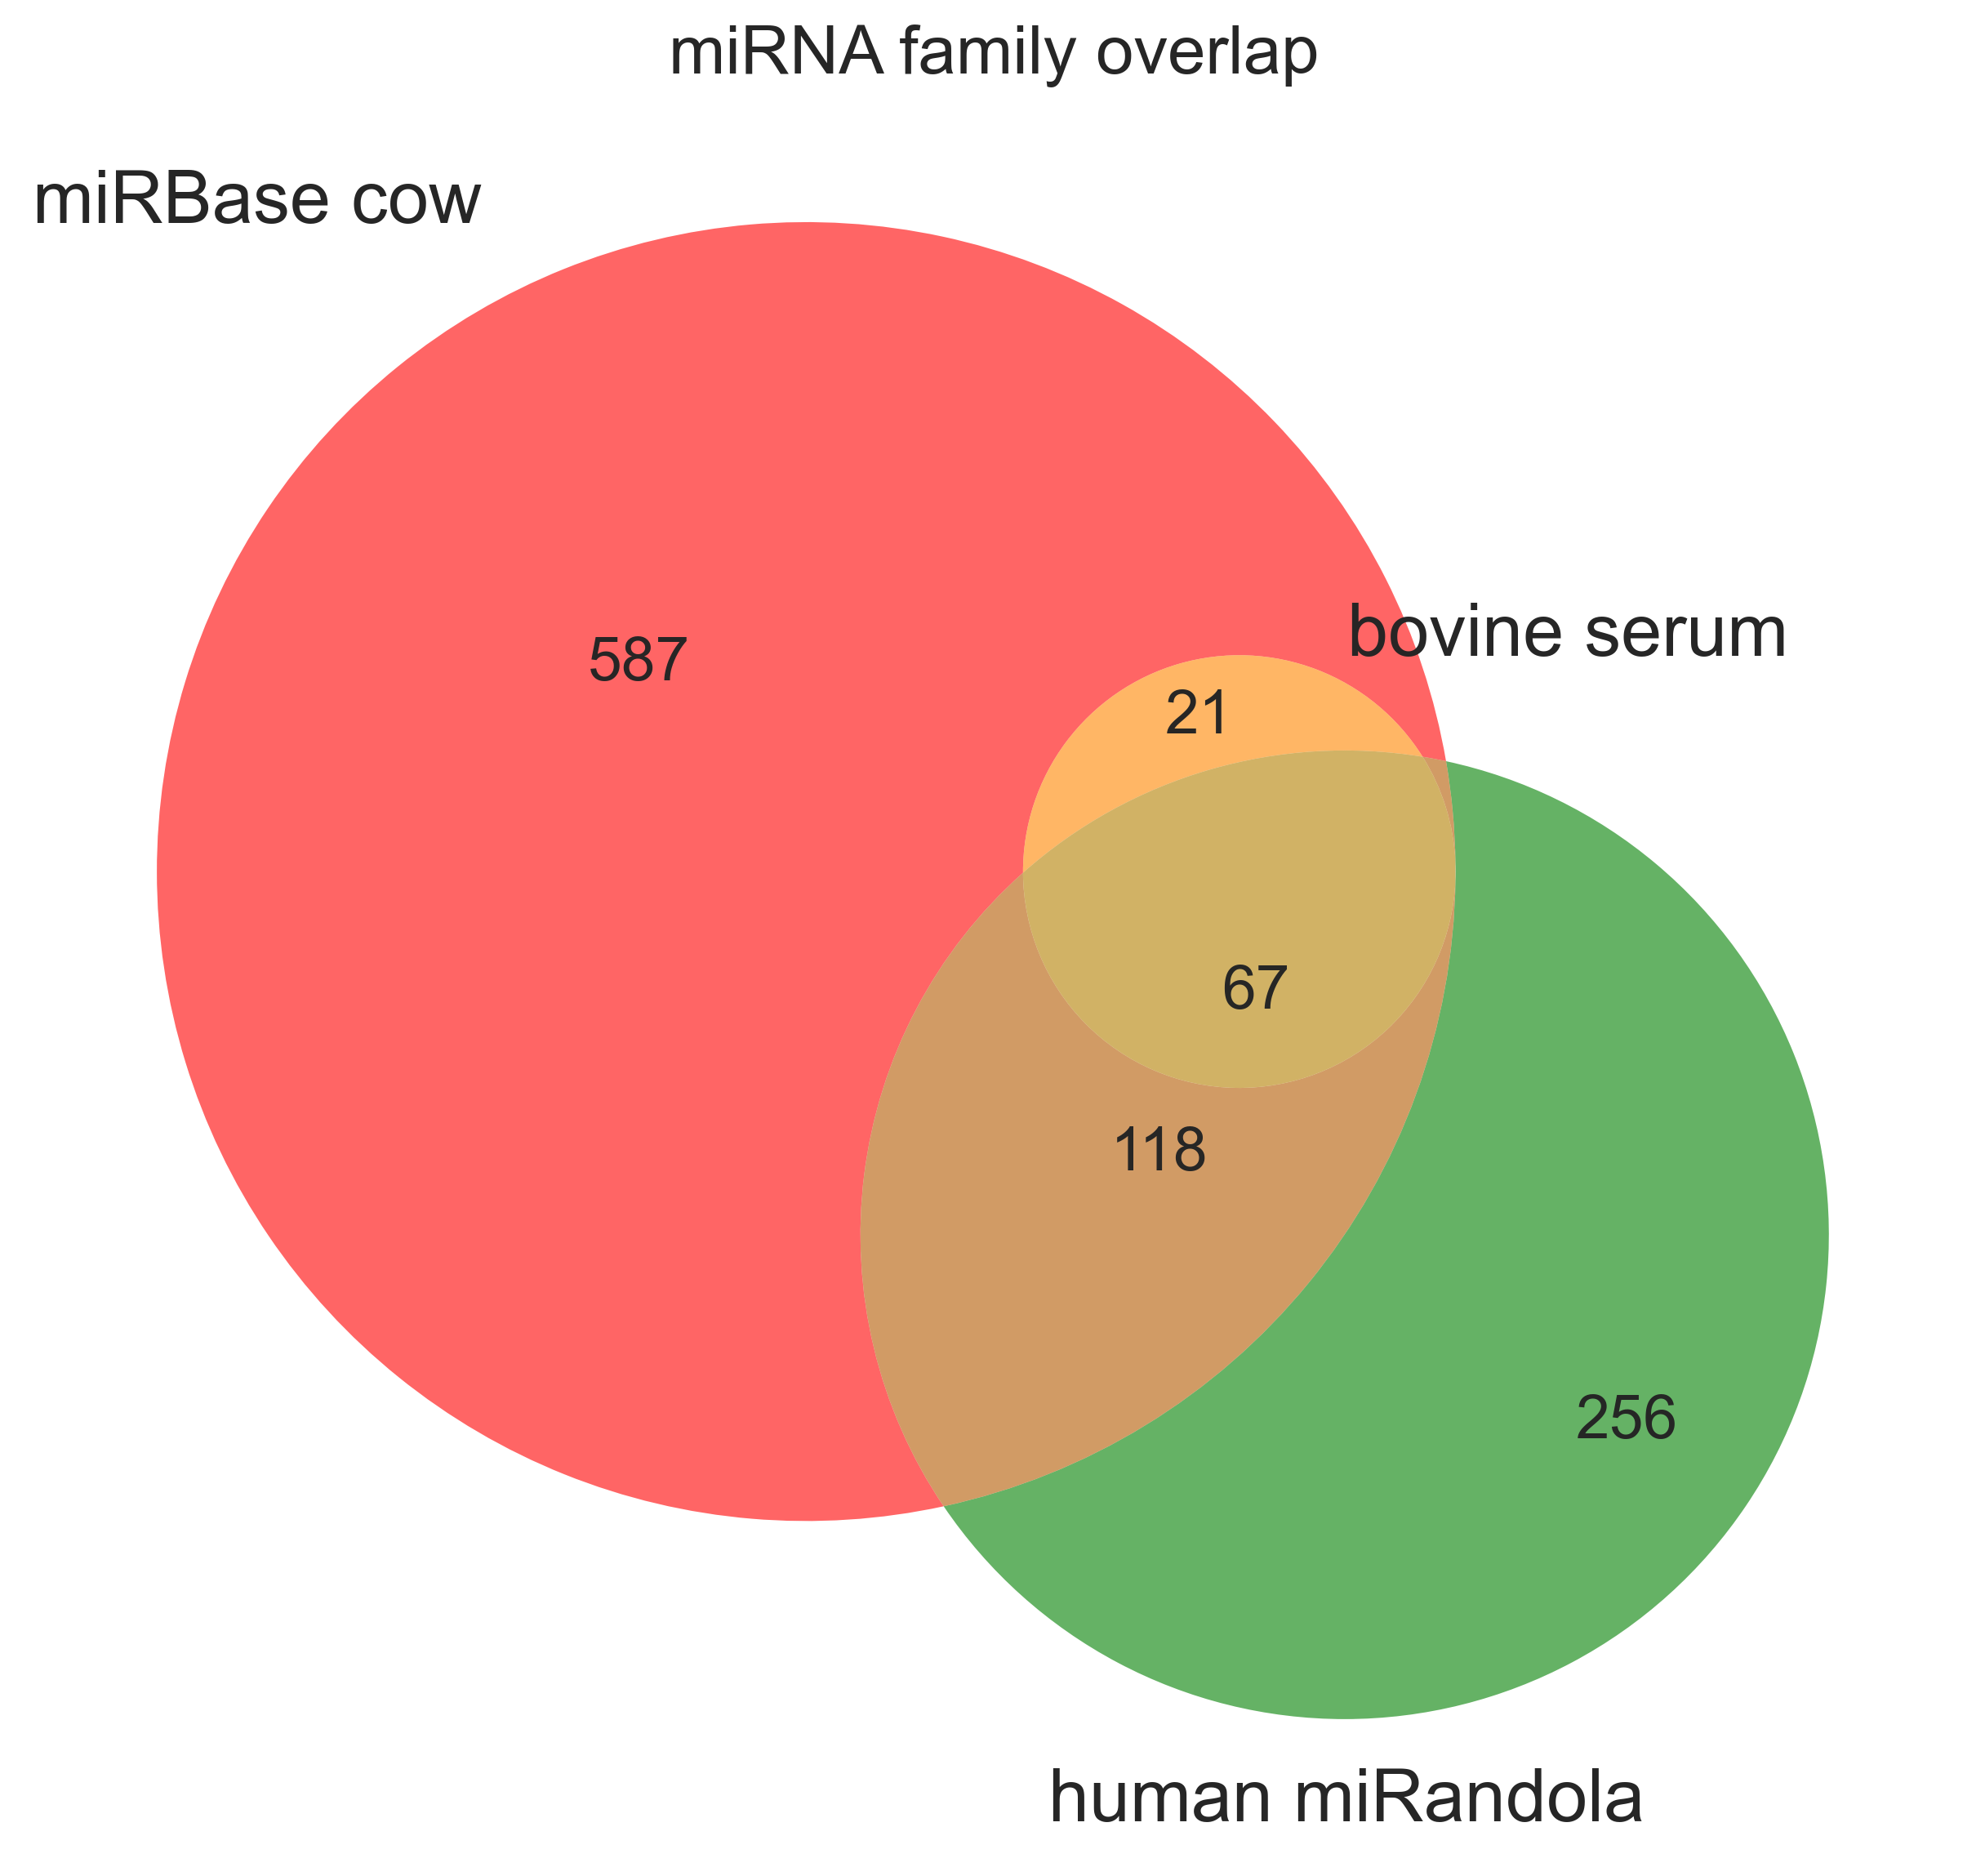

In [8]:
#overlap between our miRs and other circulating 
mirbase = base.fasta2DataFrame('mature_btau_alt.fa').reset_index()
mb = mirbase.name.str.replace('bta-','')
a=k['#miRNA'].str.replace('bta-','')
mdla = pd.read_csv('/opt/mirnaseq/analysis/miRandola_1.6.csv')
h1 = mdla[mdla.miRNA_type=='circulating'].name.str.replace('hsa-','')
f,ax=plt.subplots(1,1,figsize=(10,8))
v=base.venndiagram([mb,a,h1],['miRBase cow','bovine serum','human miRandola'],ax, set_colors=['r','y','g'], alpha=0.6)
ax.set_title('miRNA family overlap',fontsize=20)
plt.tight_layout()
f.savefig('known_overlap.png')

    index  animal  month    status      label            filename   id
5      42    2393      6  infected   sample_6   sample_6_combined  s21
6      43    2152      6  infected   sample_7   sample_7_combined  s22
12      1    2155      6  infected  sample_13  sample_13_combined  s04
17      6    2402      6  infected  sample_18  sample_18_combined  s09
22     11    2388      6  infected  sample_23  sample_23_combined  s15
23     12    2390      6  infected  sample_24  sample_24_combined  s16
[('s21', 's22'), ('s04', 's09'), ('s15', 's16')]
0    128
1      0
2    158
dtype: int64


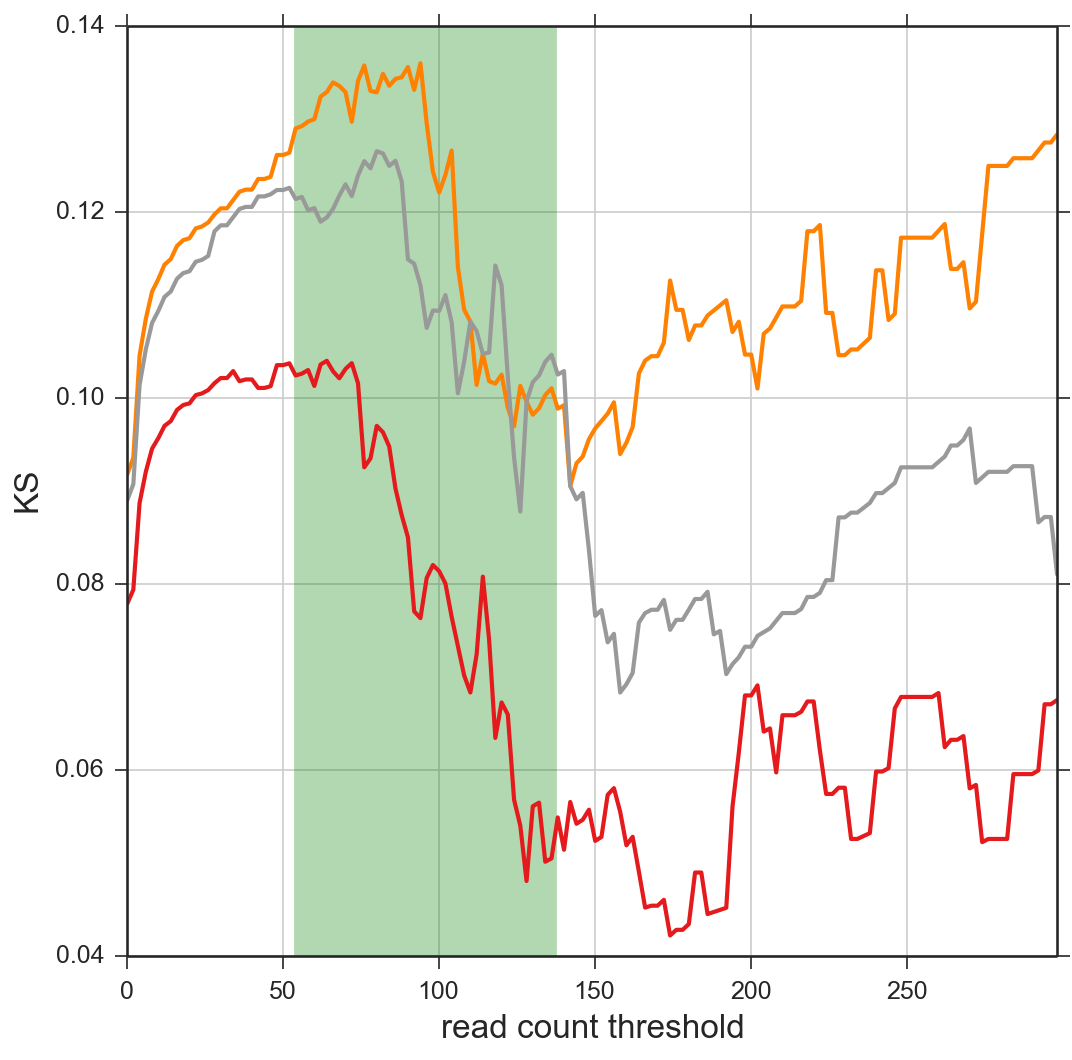

In [30]:
#ks test
reload(analysis)
c1 = condmap1[(condmap1.status=='infected') & (condmap1.month==6)]
pairs = zip(*[iter(c1.id)]*2)
print c1
print pairs
df = mdp.getResults(path1)
analysis.KStest(df, ids=pairs)
#pd.scatter_matrix(np.log(df[c1.id].replace(0,.001)))

In [41]:
reload(ensembl)
pd.set_option('display.max_colwidth', 200)
#novel
df = mdp.getResults(path1)
df = mdp.filterExprResults(df,meanreads=150,freq=0.8)
n = df[df.novel==True]
n = n[n['miRDeep2 score']>=4]
print len(n)
#print n[mdp.mirdeepcols[:9]]
#sn = n[n['#miRNA'].str.contains('26_')]
#print sn[['#miRNA','consensus precursor sequence']].sort('#miRNA')

dnov = pd.read_csv('douwe_novel_all.csv')
dnov = dnov[['precursor coordinate','total','miRDeep2 score']]

#ensembl.getmiRNAOrthologs(n)
cons = ensembl.summarise(n)
cons = cons.reset_index().merge(dnov,on='precursor coordinate',how='left',suffixes=['','_douwe'])
print cons

cons.to_csv('novel_conserved.csv',index=False)


31
      #miRNA  ident  seq      energy      tu  seedcons         biotype         gene  read_count  miRDeep2 score  \
0   20_11724  1.000   11  -34.599998  intron        11  protein_coding       DROSHA         223           133.9   
1   22_13473  1.000   11  -22.200001    exon         7           miRNA  bta-mir-191         257           133.1   
2    15_6321  0.952   10  -49.200001     NaN         4             NaN          NaN          74            79.7   
3    3_18437  0.992   10 -105.000000     NaN         0  protein_coding      SLC35D2         219           136.1   
4    3_18843  0.863    9  -42.299999     NaN         3             NaN          NaN          70            71.7   
5   28_17041  1.000    9  -24.500000     NaN         2             NaN          NaN         256             5.3   
6    13_4632  0.990    8  -91.000000  intron         4  protein_coding         SNX5        1498             5.7   
7    10_1684  0.941    7  -22.200001     NaN         0             NaN       

In [74]:
no = pd.read_csv('novel_orthologs.csv',index_col=0)
no=no.drop(['seq','gene_loc'],1)
#no.columns.insert(-1,'seq')
print no[no['#miRNA']=='26_16197']


       species    #miRNA     seed  ident  seedcons mirbase  genes                location         biotype  trscpt  energy
9   Bos taurus  26_16197  CGAGCCT    NaN        38       -  DMBT1  26:42790257-42790316:1  protein_coding  intron   -25.9
10  Ovis aries  26_16197  CGAGCCT  0.763        -1       -  DMBT1  22:41368900-41368957:1  protein_coding  intron   -11.7


intergenic    0.647727
intron        0.329545
exon          0.022727
dtype: float64


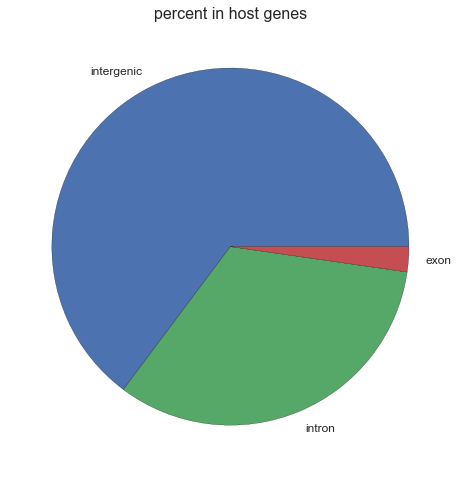

In [15]:
reload(ensembl)
#res = ensembl.getHostGenes(k)
#gk.to_csv('known_hostgenes.csv')
gk=pd.read_csv('known_hostgenes.csv')
#print gk
gk = gk.merge(k,on='#miRNA',how='right')
x = gk.tu.replace(np.nan,'intergenic').value_counts()
print x/x.sum()
x.plot(kind='pie')
plt.title('percent in host genes')

In [5]:
#biomart
from biomart import BiomartServer
#server = BiomartServer( "http://www.biomart.org/biomart" )
#print server.show_databases()

from biomart import BiomartDataset
d = BiomartDataset( "http://www.biomart.org/biomart", name = 'uniprot' )
#print d.show_filters()
#print d.show_attributes()

In [12]:
#genenames = list(no.dropna().genes.unique())
genenames = gk.dropna().gene.unique()
res=[]
for g in genenames:
    #print g
    term = {'filters': { 'gene_name': g,'proteome_name': 'Bos taurus'},
            'attributes':['accession','ensembl_id','name','go_name']}
    response = d.search(term,header=1)   
    items = [i.split('\t') for i in response.iter_lines()]
    if len(items)<2: continue
    x = pd.DataFrame(items[1:],columns=items[0])   
    res.append(x)
res = pd.concat(res)  
res['domain'] = res['GO name'].apply(lambda x: x.split(':')[0])

res = res[res.domain=='C']
ccomp = res['GO name'].value_counts()


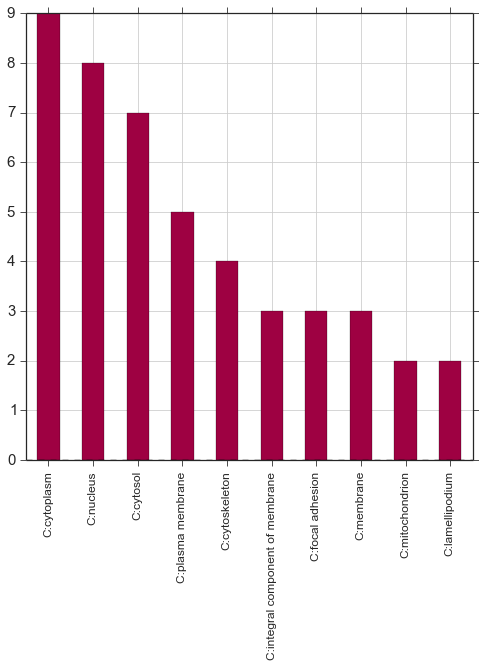

In [11]:
ccomp[:10].plot('bar',cmap='Spectral')

                 miRBase   rRNA   tRNA   sRNA  noncode  UMD3.1  unmapped
name                                                                    
2152_infected_0    0.036  0.019  0.608  0.005    0.040   0.082     0.210
2152_infected_6    0.041  0.017  0.566  0.006    0.034   0.104     0.232
2155_infected_0    0.041  0.027  0.599  0.007    0.034   0.098     0.194
2155_infected_6    0.031  0.020  0.599  0.006    0.053   0.103     0.188
2168_control_0     0.065  0.030  0.550  0.005    0.042   0.144     0.164
2168_control_6     0.066  0.035  0.529  0.004    0.058   0.130     0.178
2215_control_0     0.018  0.005  0.702  0.001    0.022   0.053     0.199
2215_control_6     0.051  0.035  0.582  0.003    0.039   0.128     0.162
2218_control_0     0.063  0.020  0.552  0.004    0.055   0.114     0.192
2218_control_6     0.041  0.025  0.536  0.005    0.052   0.101     0.240
2388_infected_0    0.025  0.022  0.601  0.005    0.036   0.083     0.228
2388_infected_6    0.038  0.018  0.604  0.006    0.

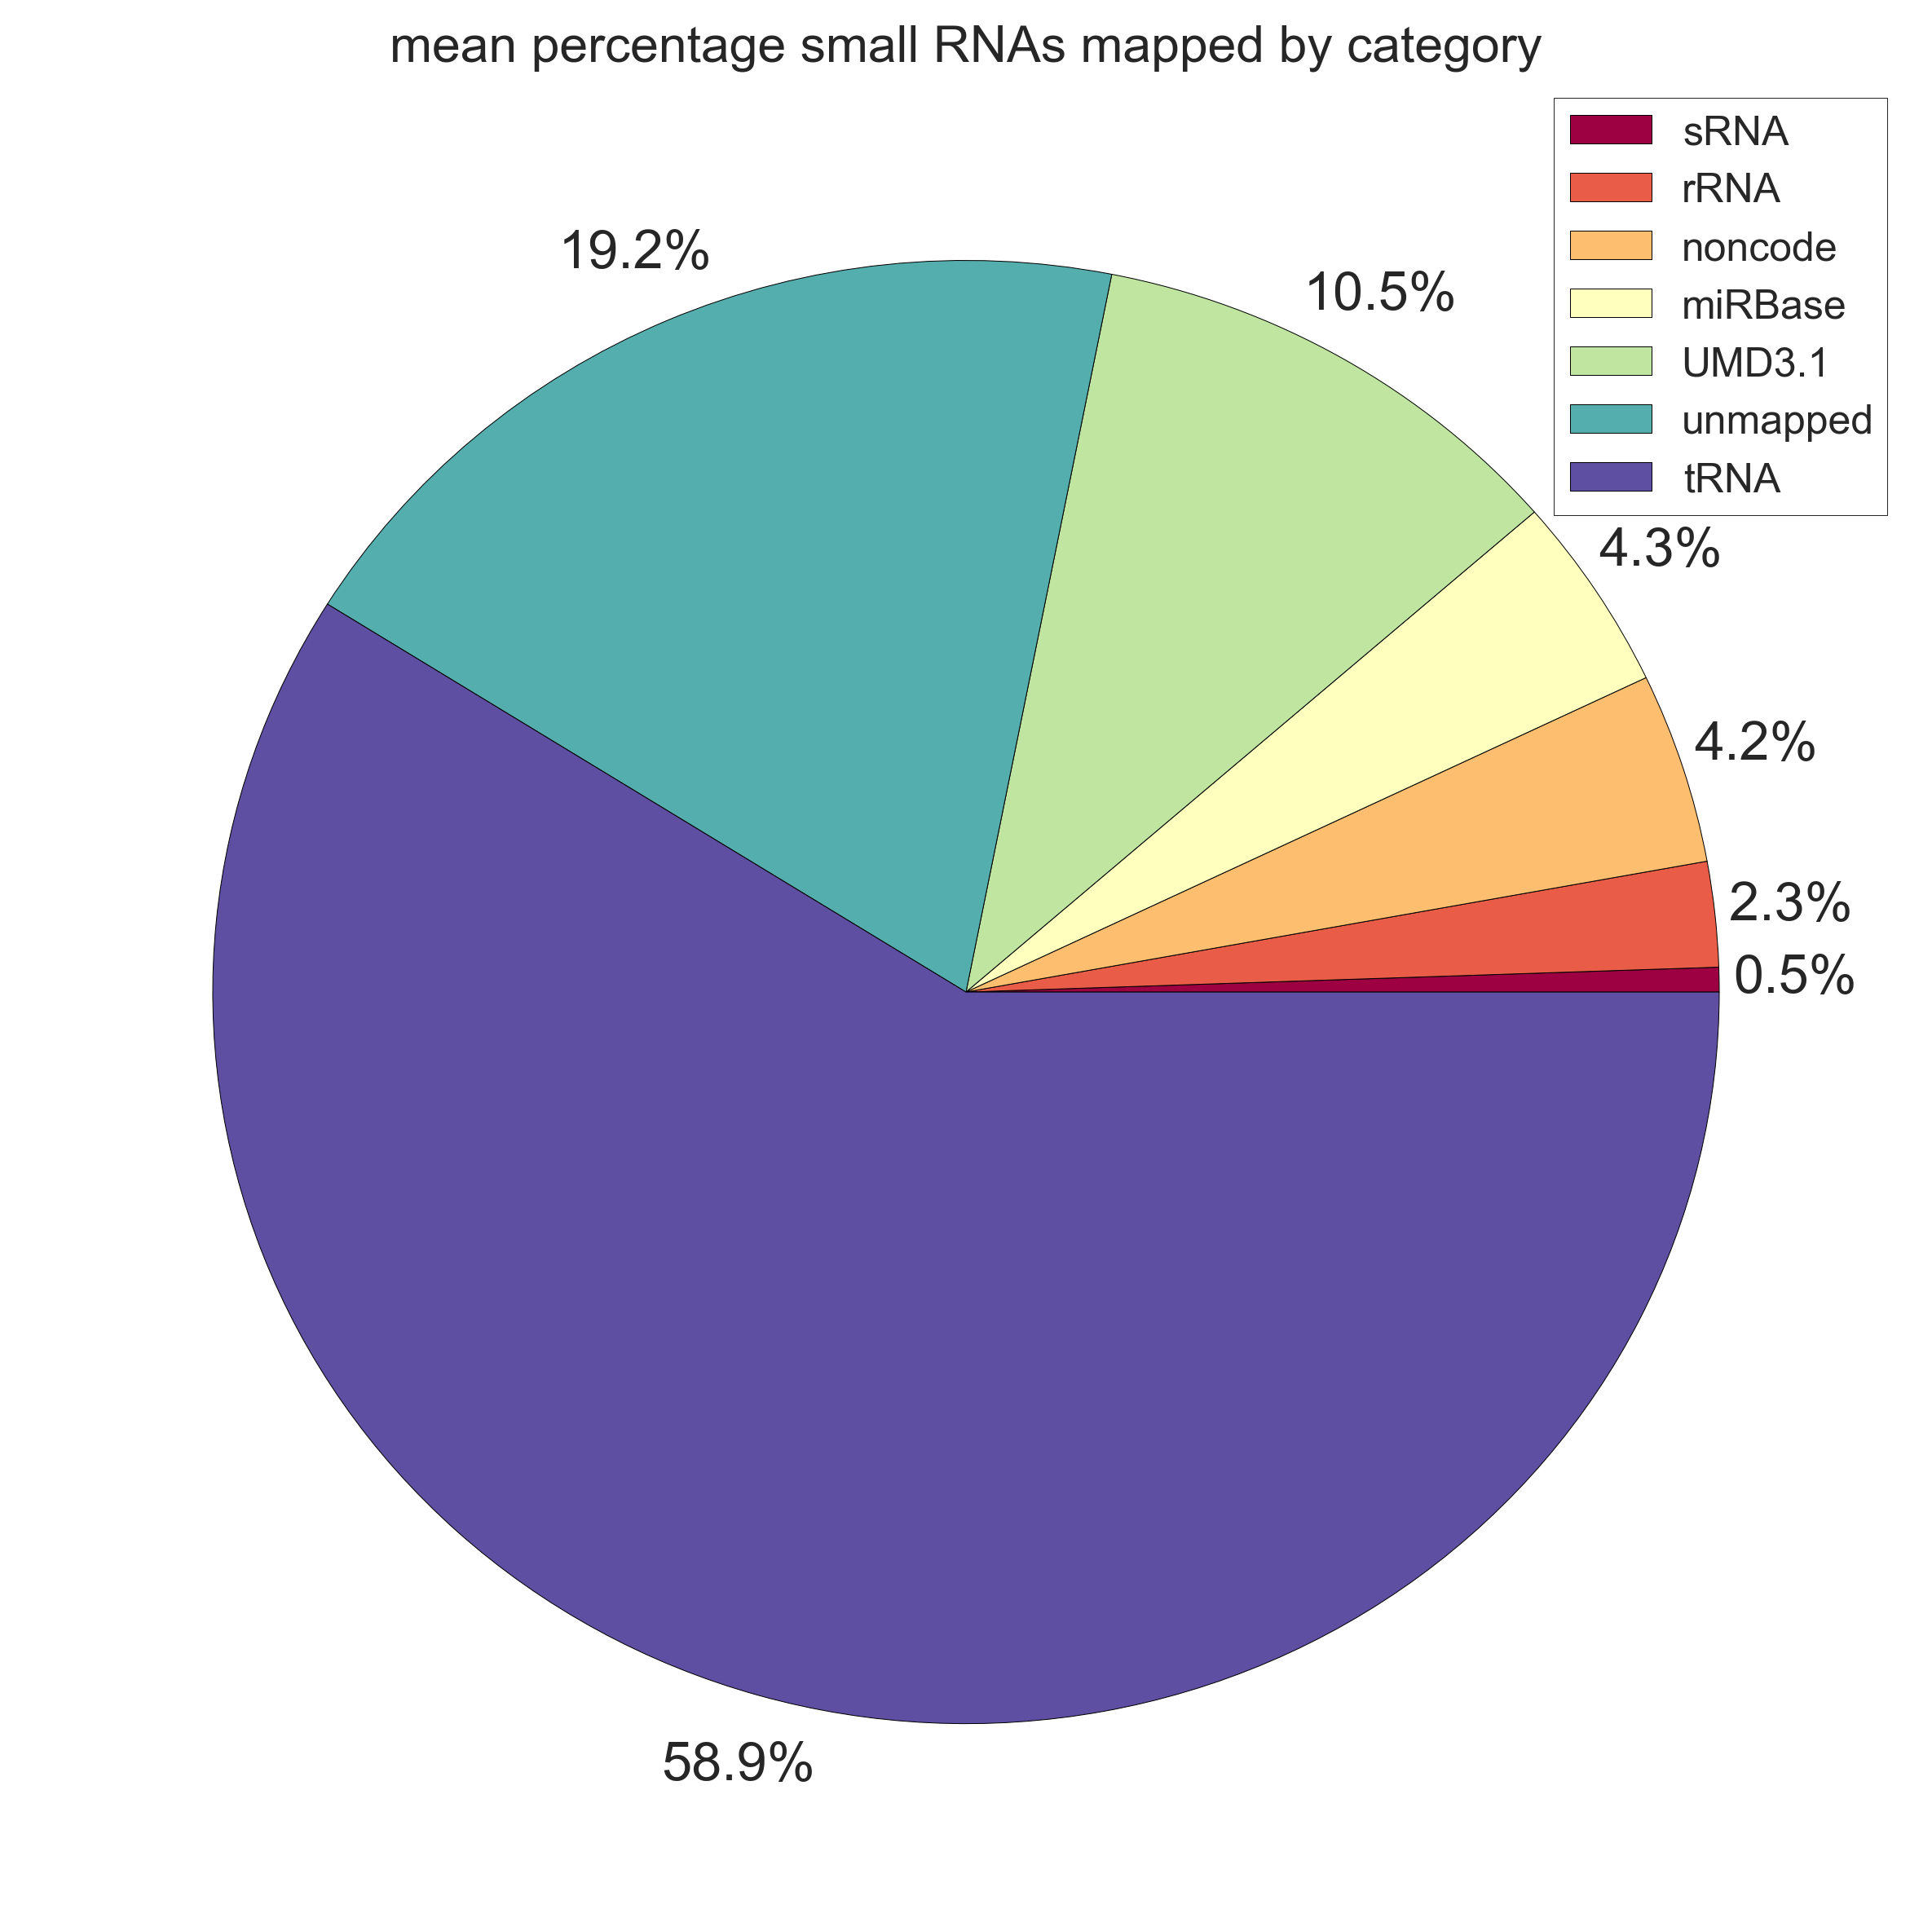

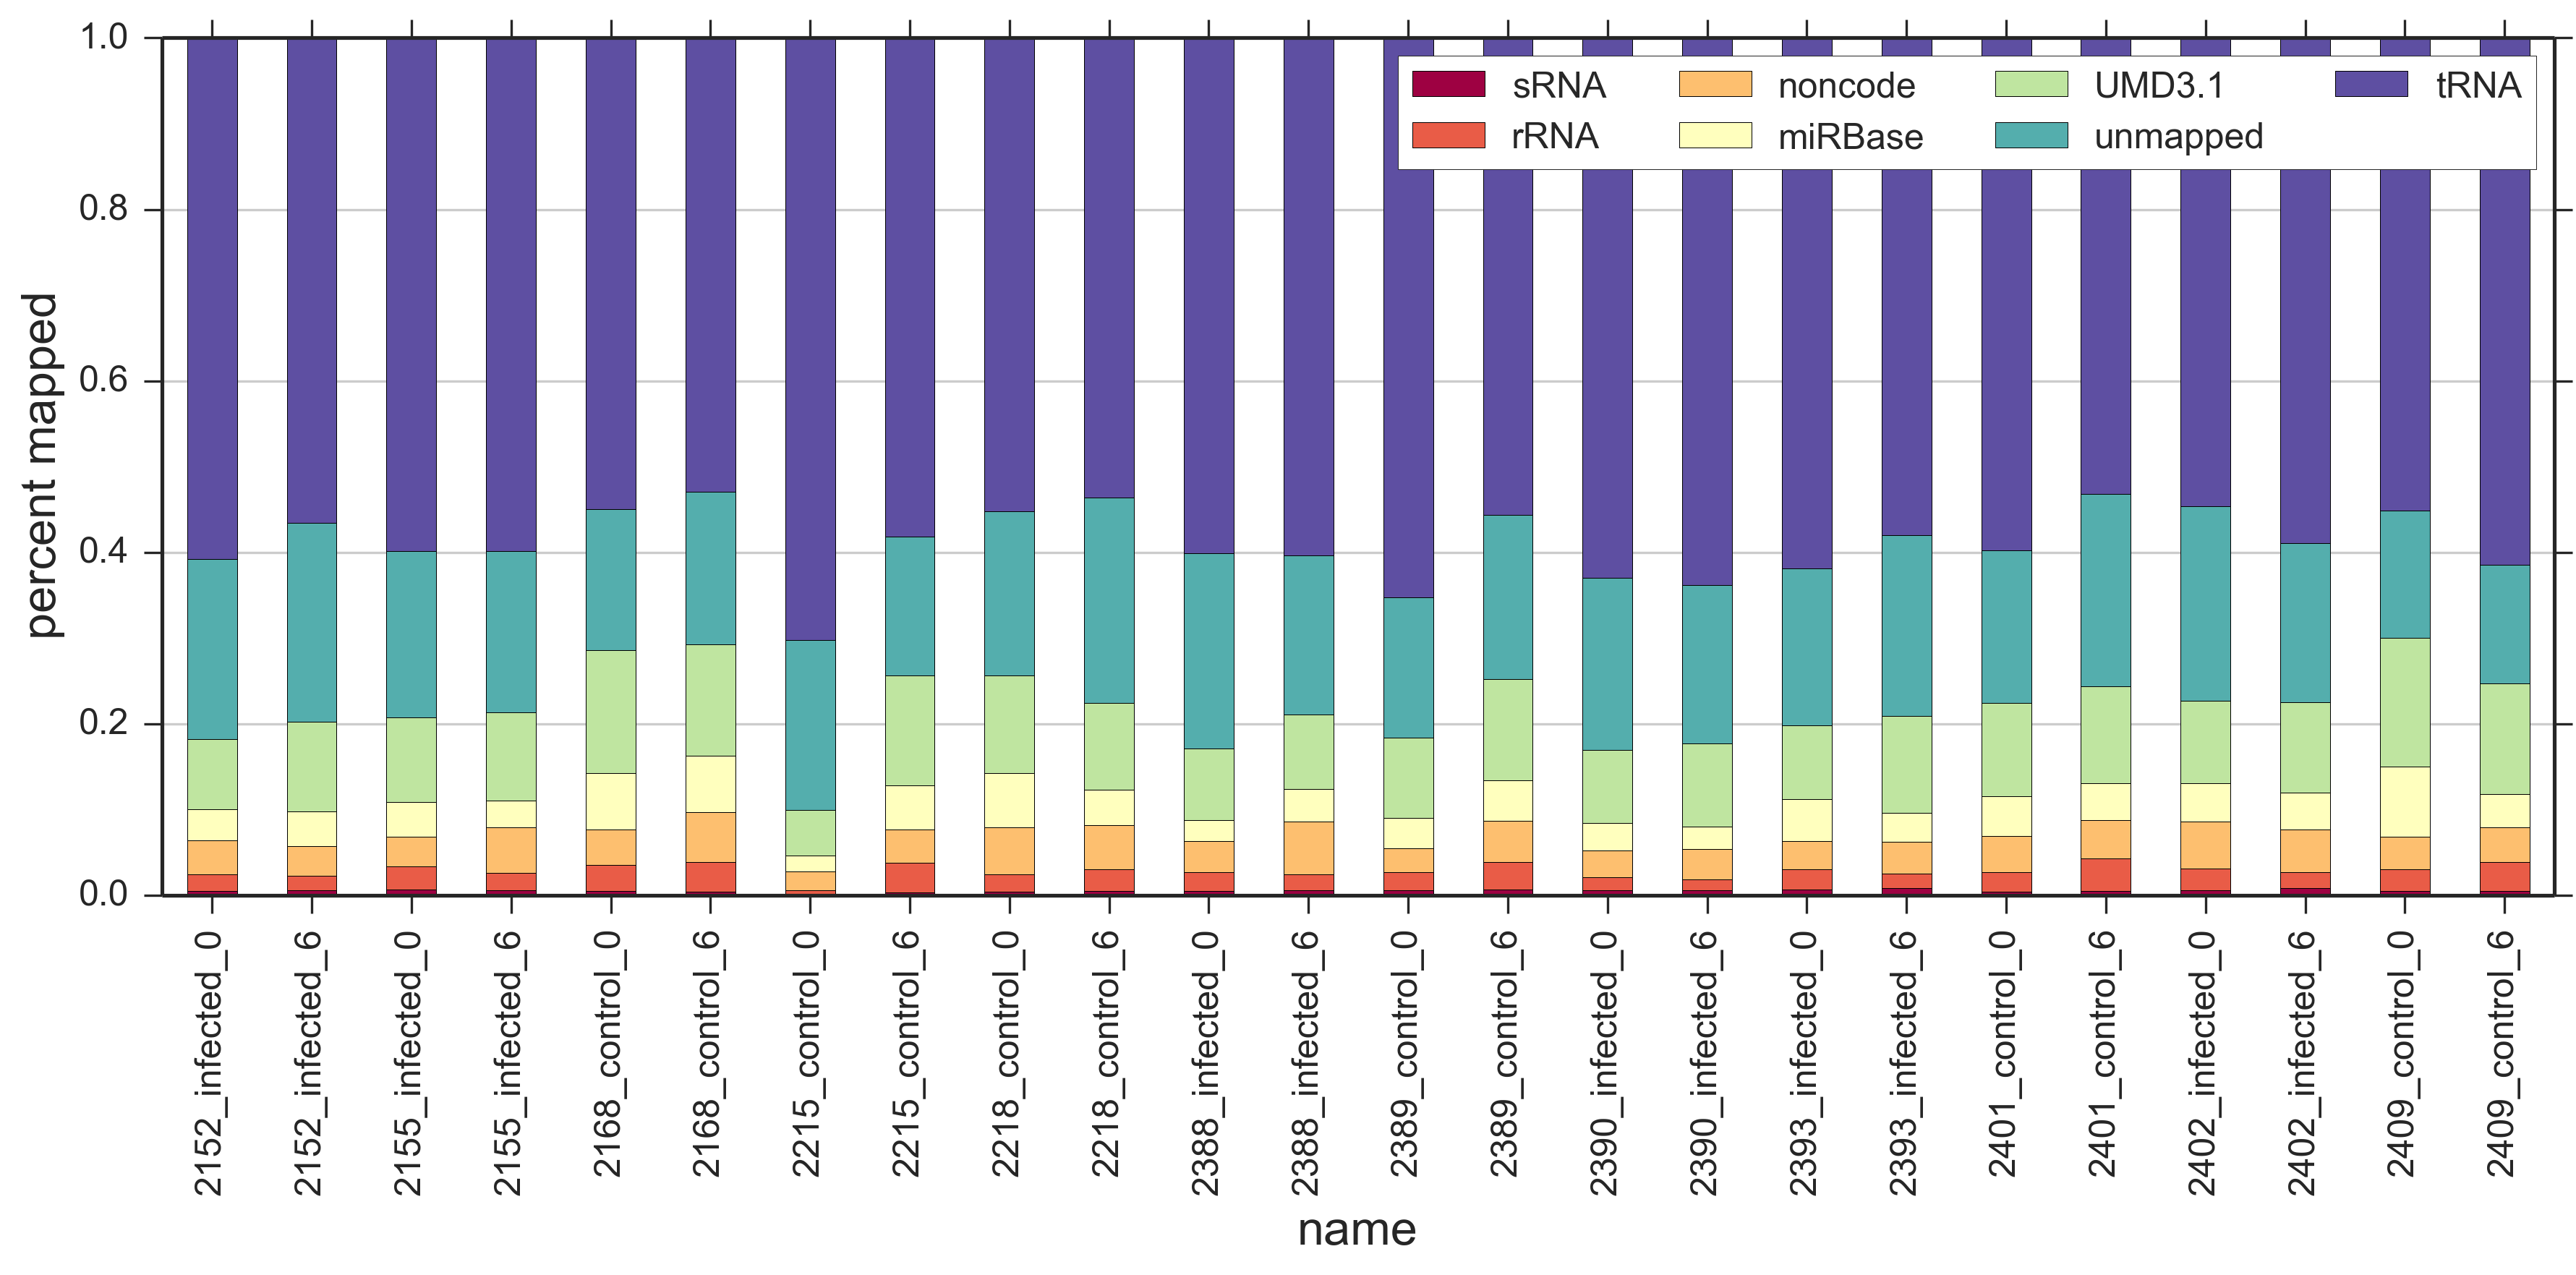

In [19]:
#customise ncrna plot
reload(analysis)
df = pd.read_csv('ncrna_mapped.csv',index_col=0)
catnames = {'mirbase-hairpin':'miRBase','Rfam_btau':'rRNA','bosTau6-tRNAs':'tRNA','unmapped':'unmapped',
        'bostau-snRNA':'sRNA','noncodev4_btau':'noncode','bos_taurus_alt':'UMD3.1'}
samples = pd.read_csv('samplelabels.csv')
df = df.rename(columns=catnames)
cols = df.columns
x = df.merge(samples,left_on='name',right_on='filename')
x['name'] = x.apply(lambda r: str(r.animal)+'_'+r.status+'_'+str(r.month),1)
x=x.sort('name')
#for i,g in x.groupby('month'):
analysis.plotRNAmapped(x[cols])


    reads  total  frac     rcm
0    0.05     41    41  464288
1    0.10     56    56    6406
2    0.20     73    73    3412
3    0.50     93    93    1399
4    1.00    118   118     636
5    1.50    129   129     357
6    2.00    140   140     216
7    2.50    151   151     159
8    3.00    163   163     146
9    3.50    167   167      65
10   4.00    167   167     NaN
11   4.50    171   171      65
12   5.00    176   176      56
13   5.50    178   178      38
14   6.00    181   181      53
15   6.50    182   182      38
    reads  total  frac     rcm
0    0.05     46    46  496131
1    0.10     63    63    6466
2    0.20     82    82    3442
3    0.50    108   108    1383
4    1.00    134   134     569
5    1.50    146   146     357
6    2.00    160   160     217
7    2.50    172   172     159
8    3.00    184   184     146
9    3.50    190   190      81
10   4.00    191   191      67
11   4.50    197   197      65
12   5.00    203   203      61
13   5.50    205   205      38
14   6.0

/usr/lib/pymodules/python2.7/matplotlib/figure.py:1595: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


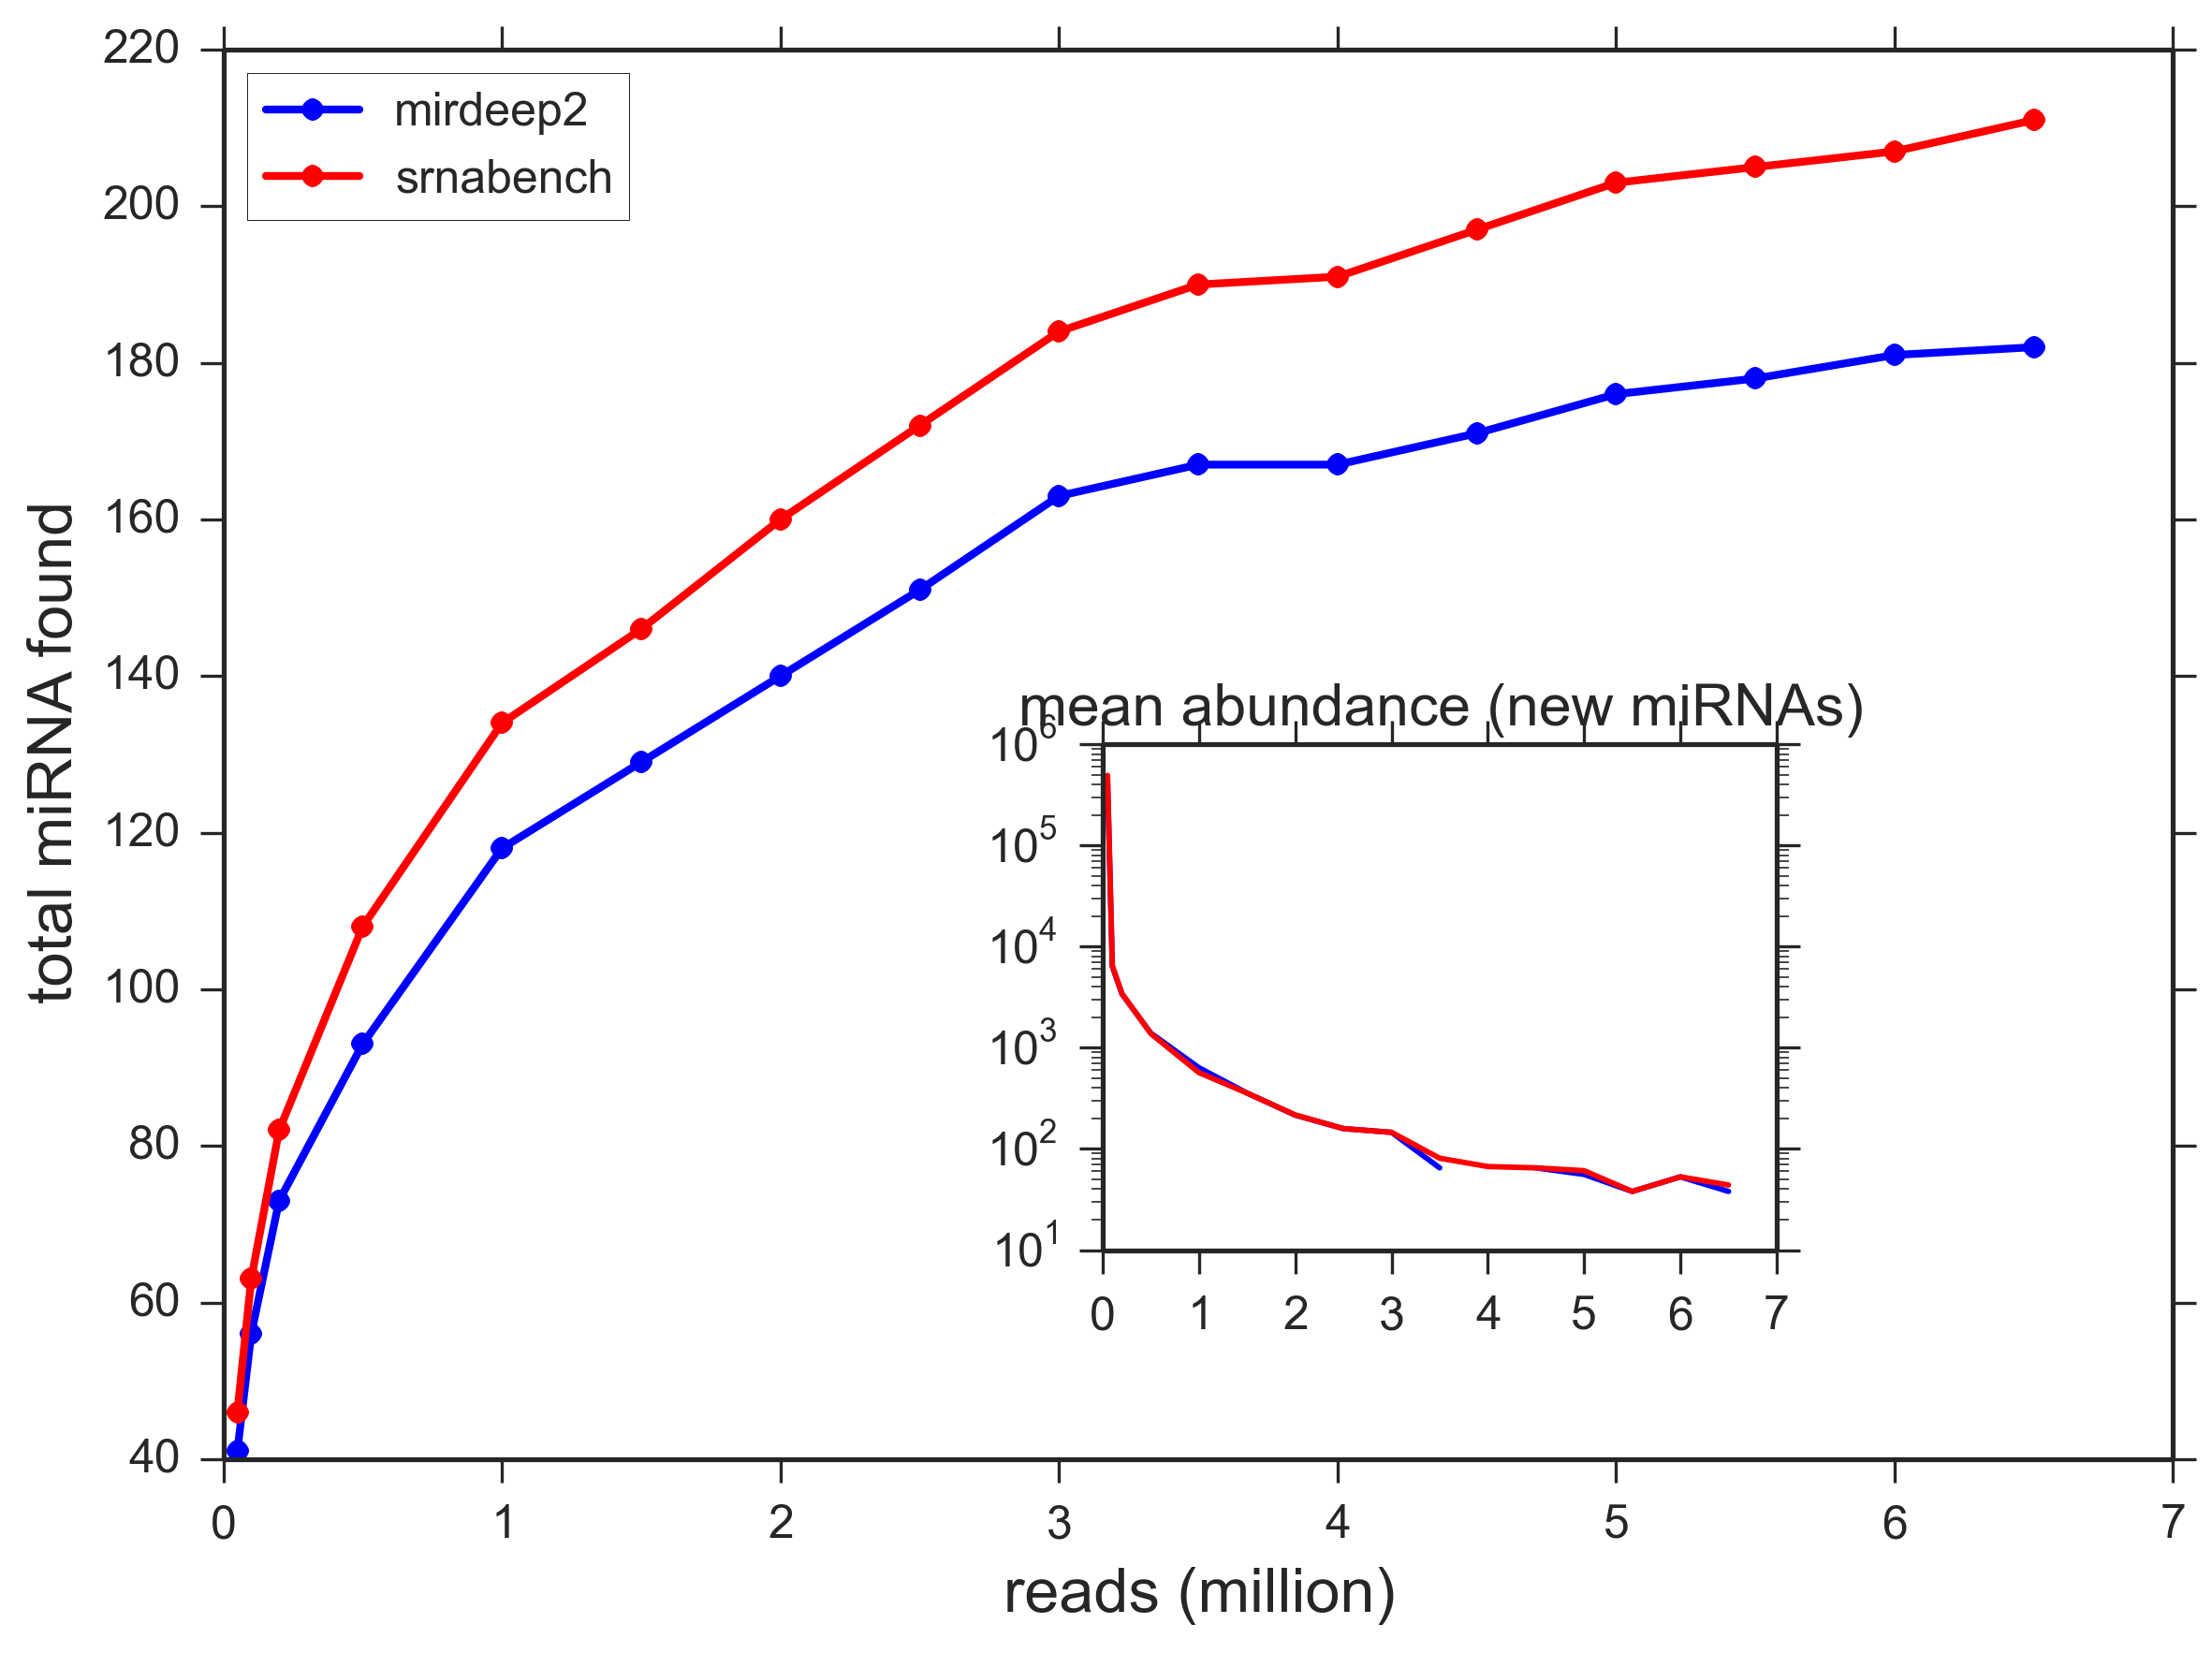

In [21]:
reload(analysis)
infile = '/opt/mirnaseq/data/iconmap_feb15/combined/ncrna_map/sample_1_combined_cut.fastq'
analysis.mirnaDiscoveryTest(infile)

In [66]:
#rna structures
reload(base)
names=['20_11724','22_13473','15_6321','3_18437','3_18517','26_16197']
x=n.set_index('#miRNA')
for i,r in x.iterrows():
    if i not in names:
        continue
    seq = r['consensus precursor sequence']
    mature = r['consensus mature sequence']
    star = r['consensus star sequence']
    print i, mature, star    
    struct = base.plotRNA(seq, path=os.getcwd(), subseqs=[mature,star], name=i)

3_18517 aaaaaccugaaugacccuuuug aaaagguucauuuggguuuc
26_16197 ccgagccugacagaucacaca gugugaccugccaggcacc
22_13473 gaacgaaauccaagcgcagcug gcugcuuuugggauuccguugc
20_11724 ucuugggccccacccccggagac aucugggguagggccuggga
3_18437 ccggccccgcgagcuccccgcga cggggagccgaggcggccagc
15_6321 aggcucgggcugggccccggg ccgggccugggccgagcccca
